In [139]:
# Get and process input data
import pandas as pd
import numpy as np

var = dict([ (1, ('WHITE',1)),(2, ('ALCHY',1)),(3, ('JUNKY',1)),(4, ('SUPER',1)),
                (5, ('MARRIED',1)),(6, ('FELON',1)),(7, ('WORKREL',1)),(8, ('PROPTY',1)),
                (9, ('PERSON',1)),(10, ('MALE',1)),(11, ('PRIORS',2)),(13, ('SCHOOL',2)),
                (15, ('RULE',2)),(17, ('AGE',3)),(20, ('TSERVD',3)),
                (23, ('FOLLOW',2)),(25, ('RECID',1)),(26, ('TIME',2)),(28, ('FILE',1)) ] )

def cleanData(data):
    res = []
    cols = [x[1][0] for x in var.items()] # Get the column names
    for line in data:
        line = line.strip()
        
        curLine = []
        for i in xrange(len(line)):
            if i+1 not in var:
                continue
            name, sz = var[i+1]            
            curLine.append(int(line[i:i+sz]))
        
        res.append(curLine)
    
    ret = pd.DataFrame(data=res, columns=cols)
    ret = ret[ret.FILE != 3] # Remove incomplete data points
    
    # Remove some irrelevant columns
    del ret['TIME']
    del ret['FILE']
    del ret['FOLLOW']
    return ret
    

raw_1978 = open('data/1978.txt','rb').readlines()
raw_1980 = open('data/1980.txt','rb').readlines()


d1978 = cleanData(raw_1978)
d1980 = cleanData(raw_1980)

print d1978.head()
print len(d1978)


    WHITE  ALCHY  JUNKY  SUPER  MARRIED  FELON  WORKREL  PROPTY  PERSON  MALE  \
2       1      1      0      1        1      0        1       0       0     1   
3       1      0      0      1        1      0        0       0       0     1   
6       1      0      0      1        0      0        1       0       0     1   
10      1      0      0      0        0      0        1       0       0     0   
11      0      0      0      0        0      1        0       0       0     1   

    PRIORS  SCHOOL  RULE  AGE  TSERVD  RECID  
2        0       7     2  441      30      0  
3        0      11     0  303       4      0  
6        1       9     1  276      43      1  
10       0      14     0  329       9      0  
11       0      10     0  277       8      0  
4618


In [159]:
# Neural network for CS 281
# Reference: http://pybrain.org/docs/tutorial

import pybrain
from pybrain.tools.shortcuts import buildNetwork
from pybrain.structure import SoftmaxLayer, TanhLayer
from pybrain.datasets import ClassificationDataSet
from pybrain.supervised.trainers import BackpropTrainer
from pybrain.utilities import percentError
import pickle

def createTrainTest(df, cutProp = 0.3):
    '''
    Input:
        df: Pandas dataframe
        cutProp (default = 0.3): Proportion of samples in the test/validation set
    
    Output:
        trainD: ClassificationDataSet 
        testD: ClassificationDataSet        
    '''
    # Load the dataframe data into the pybrain data set
    np_d1978 = (df.values).astype(float)
    np.random.shuffle(np_d1978)
    cutoff = int(np_d1978.shape[0] * cutProp) # < cutoff is the test set, otherwise training set

    # Normalize
    for c in xrange( np_d1978.shape[1] - 1):
        c_sd = np.std(np_d1978[cutoff:, c])
        c_mean = np.mean(np_d1978[cutoff:, c])

        np_d1978[cutoff:, c] = (np_d1978[cutoff:, c] - c_mean) / c_sd

        # Normalize the test set as well
        np_d1978[:cutoff, c] = (np_d1978[:cutoff, c] - c_mean) / c_sd   

    testD = ClassificationDataSet(np_d1978.shape[1]-1, nb_classes=2, class_labels=['No', 'Yes'])
    trainD = ClassificationDataSet(np_d1978.shape[1]-1, nb_classes=2, class_labels=['No', 'Yes'])    
    

    for r_idx in xrange(len(np_d1978)):
        r = np_d1978[r_idx, :]
        inD, outD = r[:-1], r[-1]

        if r_idx < cutoff:
            testD.appendLinked(inD, outD)
        else:
            trainD.appendLinked(inD, outD)

    # net = buildNetwork(2, 3, 1, hiddenclass=TanhLayer, outclass=SoftmaxLayer)
    trainD._convertToOneOfMany(bounds=[0,1])
    testD._convertToOneOfMany(bounds=[0,1])
    
    return trainD, testD


def findBest(trainD, testD, lower = 3, upper = 26, skip = 1):
    resErr = []

    for hid in xrange(lower, upper, skip):
        print 'Trying with', hid, 'hidden layers...'
        net = buildNetwork(trainD.indim, hid, trainD.outdim, bias=True)
        t = BackpropTrainer(net, dataset=trainD)    

        bestEpoch = None
        bestErr = 101.
        bestTrErr = 101.
        b0Corr = None
        b1Corr = None

        totalIt = 1000
        epPerIt = 10
        maxContinueEpochs = 100

        for it in xrange(totalIt):    
            #     t.trainUntilConvergence(maxEpochs=2000)

            t.trainEpochs(epPerIt)
            testRes = t.testOnClassData(dataset=testD)
            trnresult = percentError( t.testOnClassData(),
                                      trainD['class'] )
            tstresult = percentError( testRes, testD['class'] )

            N1, N0 = 0, 0
            c_1, c_0 = 0, 0
            for i in xrange(len(testRes)):
                if testD['class'][i] == 0:
                    N0 += 1
                    if testRes[i] == 0:
                        c_0 += 1
                else:
                    N1 += 1
                    if testRes[i] == 1:
                        c_1 += 1

            if tstresult < bestErr:
                bestErr = tstresult
                bestTrErr = trnresult
                bestEpoch = t.totalepochs  
                b0Corr = float(c_0)/float(N0)
                b1Corr = float(c_1)/float(N1)

            print 'Prop. of 1s:', sum(testRes)/float(len(testRes))
            print '% of class 0 correct:', float(c_0)/float(N0)
            print '% of class 1 correct:', float(c_1)/float(N1)

            print "epoch: %4d" % t.totalepochs, \
                  "  train acc: %5.2f%%" % (100-trnresult), \
                  "  test acc: %5.2f%%" % (100-tstresult)

            # How long since the last best was found?
            if  t.totalepochs - bestEpoch > maxContinueEpochs:
                print 'Finishing with this cycle; no better scores seen for a while' 
                break

        resErr.append( (bestErr, bestTrErr, hid, bestEpoch, b0Corr, b1Corr, t) )
        print resErr[-1]
    
    return sorted(resErr)


# print np_d1978[:5]
# print trainD['target']


trainD, testD = createTrainTest(d1978)

print trainD.calculateStatistics()
print testD.calculateStatistics()

sRes = findBest(trainD, testD, 3, 22, 1)

print sRes

# Reference: http://stackoverflow.com/questions/6568007/how-do-i-save-and-restore-multiple-variables-in-python
with open('1978_best_trainer.pickle', 'w') as f:
    pickle.dump(sRes[0][-1], f)

with open('1978_res.log', 'w') as f:
    f.write(str(sRes))
    
    
    
trainD, testD = createTrainTest(d1980)

print trainD.calculateStatistics()
print testD.calculateStatistics()

sRes = findBest(trainD, testD, 3, 22, 1)

print sRes

# Reference: http://stackoverflow.com/questions/6568007/how-do-i-save-and-restore-multiple-variables-in-python
with open('1980_best_trainer.pickle', 'w') as f:
    pickle.dump(sRes[0][-1], f)

with open('1980_res.log', 'w') as f:
    f.write(str(sRes))


{0: 2001, 1: 1232}
{0: 896, 1: 489}
Trying with 3 hidden layers...
Prop. of 1s: 0.308303249097
% of class 0 correct: 0.766741071429
% of class 1 correct: 0.445807770961
epoch:   10   train acc: 63.44%   test acc: 65.34%
Prop. of 1s: 0.284476534296
% of class 0 correct: 0.814732142857
% of class 1 correct: 0.466257668712
epoch:   20   train acc: 67.96%   test acc: 69.17%
Prop. of 1s: 0.185559566787
% of class 0 correct: 0.887276785714
% of class 1 correct: 0.319018404908
epoch:   30   train acc: 68.08%   test acc: 68.66%
Prop. of 1s: 0.172563176895
% of class 0 correct: 0.8984375
% of class 1 correct: 0.302658486708
epoch:   40   train acc: 68.02%   test acc: 68.81%
Prop. of 1s: 0.180505415162
% of class 0 correct: 0.896205357143
% of class 1 correct: 0.321063394683
epoch:   50   train acc: 67.96%   test acc: 69.31%
Prop. of 1s: 0.324187725632
% of class 0 correct: 0.78125
% of class 1 correct: 0.517382413088
epoch:   60   train acc: 68.05%   test acc: 68.81%
Prop. of 1s: 0.209386281588

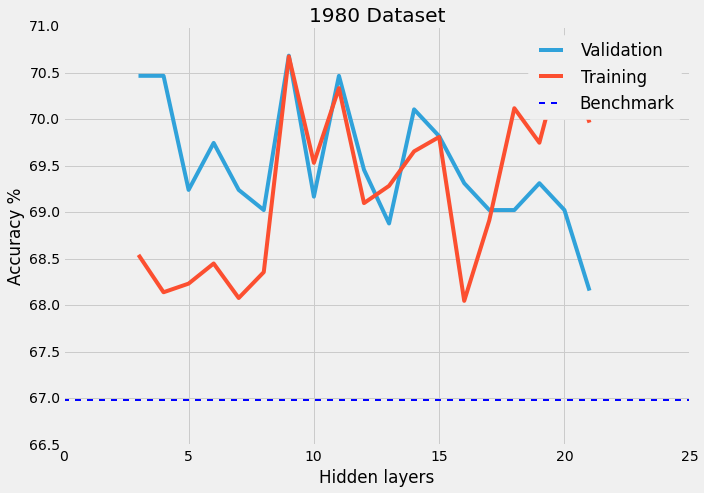

In [184]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 7))
vRes = sorted(sRes, key=lambda x: x[2])
plt.plot(range(3, 22, 1), [100 - x[0] for x in vRes], label='Validation')
plt.plot(range(3, 22, 1), [100 - x[1] for x in vRes], label='Training')
plt.axhline(66.98, label='Benchmark', ls='--', lw=2)
plt.xlabel('Hidden layers')
plt.ylabel('Accuracy %')
plt.legend()
plt.title('1980 Dataset')
plt.show()

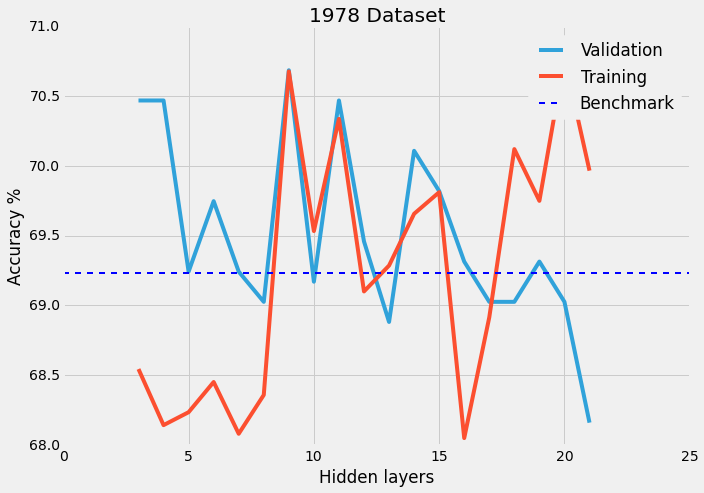

In [183]:
import matplotlib.pyplot as plt
%matplotlib inline

sRes = [(29.314079422382672, 29.322610578410146, 9, 170, 0.8426339285714286, 0.45807770961145194), (29.530685920577618, 29.662851840395916, 11, 170, 0.8638392857142857, 0.4130879345603272), (29.530685920577618, 31.45685122177544, 3, 70, 0.8828125, 0.3783231083844581), (29.530685920577618, 31.85895453139499, 4, 30, 0.8727678571428571, 0.3967280163599182), (29.891696750902526, 30.34333436436746, 14, 90, 0.8236607142857143, 0.47648261758691207), (30.180505415162454, 30.18867924528302, 15, 40, 0.8571428571428571, 0.4069529652351738), (30.252707581227437, 31.549644293226105, 6, 130, 0.8325892857142857, 0.4498977505112474), (30.541516245487365, 30.90009279307145, 12, 130, 0.9319196428571429, 0.25971370143149286), (30.685920577617328, 30.250541292916797, 19, 50, 0.8515625, 0.40286298568507156), (30.685920577617328, 31.951747602845654, 16, 20, 0.8895089285714286, 0.3333333333333333), (30.75812274368231, 31.766161459944325, 5, 60, 0.8381696428571429, 0.42535787321063395), (30.75812274368231, 31.920816579028767, 7, 40, 0.8549107142857143, 0.3946830265848671), (30.830324909747294, 30.467058459635012, 10, 60, 0.8303571428571429, 0.4376278118609407), (30.974729241877256, 29.22981750695948, 20, 70, 0.8683035714285714, 0.36400817995910023), (30.974729241877256, 29.879369007114136, 18, 60, 0.8950892857142857, 0.3149284253578732), (30.974729241877256, 31.08567893597278, 17, 20, 0.8627232142857143, 0.37423312883435583), (30.974729241877256, 31.64243736467677, 8, 40, 0.8337053571428571, 0.4274028629856851), (31.119133574007222, 30.714506650170122, 13, 120, 0.90625, 0.2903885480572597), (31.84115523465704, 30.034024126198577, 21, 50, 0.8861607142857143, 0.3067484662576687)]

plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 7))
vRes = sorted(sRes, key=lambda x: x[2])
plt.plot(range(3, 22, 1), [100 - x[0] for x in vRes], label='Validation')
plt.plot(range(3, 22, 1), [100 - x[1] for x in vRes], label='Training')
plt.axhline(69.23, label='Benchmark', ls='--', lw=2)
plt.xlabel('Hidden layers')
plt.ylabel('Accuracy %')
plt.legend()
plt.title('1978 Dataset')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

sRes = [(29.314079422382672, 29.322610578410146, 9, 170, 0.8426339285714286, 0.45807770961145194), (29.530685920577618, 29.662851840395916, 11, 170, 0.8638392857142857, 0.4130879345603272), (29.530685920577618, 31.45685122177544, 3, 70, 0.8828125, 0.3783231083844581), (29.530685920577618, 31.85895453139499, 4, 30, 0.8727678571428571, 0.3967280163599182), (29.891696750902526, 30.34333436436746, 14, 90, 0.8236607142857143, 0.47648261758691207), (30.180505415162454, 30.18867924528302, 15, 40, 0.8571428571428571, 0.4069529652351738), (30.252707581227437, 31.549644293226105, 6, 130, 0.8325892857142857, 0.4498977505112474), (30.541516245487365, 30.90009279307145, 12, 130, 0.9319196428571429, 0.25971370143149286), (30.685920577617328, 30.250541292916797, 19, 50, 0.8515625, 0.40286298568507156), (30.685920577617328, 31.951747602845654, 16, 20, 0.8895089285714286, 0.3333333333333333), (30.75812274368231, 31.766161459944325, 5, 60, 0.8381696428571429, 0.42535787321063395), (30.75812274368231, 31.920816579028767, 7, 40, 0.8549107142857143, 0.3946830265848671), (30.830324909747294, 30.467058459635012, 10, 60, 0.8303571428571429, 0.4376278118609407), (30.974729241877256, 29.22981750695948, 20, 70, 0.8683035714285714, 0.36400817995910023), (30.974729241877256, 29.879369007114136, 18, 60, 0.8950892857142857, 0.3149284253578732), (30.974729241877256, 31.08567893597278, 17, 20, 0.8627232142857143, 0.37423312883435583), (30.974729241877256, 31.64243736467677, 8, 40, 0.8337053571428571, 0.4274028629856851), (31.119133574007222, 30.714506650170122, 13, 120, 0.90625, 0.2903885480572597), (31.84115523465704, 30.034024126198577, 21, 50, 0.8861607142857143, 0.3067484662576687)]

plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 7))
vRes = sorted(sRes, key=lambda x: x[2])
plt.plot(range(3, 22, 1), [100 - x[0] for x in vRes], label='Validation')
# plt.plot(range(3, 22, 1), [100 - x[1] for x in vRes], label='Training')
plt.axhline(69.23, label='Benchmark', ls='--', lw=2)
plt.xlabel('Hidden layers')
plt.ylabel('Accuracy %')
plt.legend()
plt.title('1978 Dataset')
plt.show()